In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
% autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
import sys
sys.path.append('/users/amyskerry/documents/projects')
from pybq import core, util, bqdf
from pybq import credentialscfg as cfg

#Utility functions for viewing/modifying what data are available 

service=util.get_service()
projects=util.list_projects(service)
datasets=util.list_datasets(service, 'durable-footing-95814')
tables=util.list_tables(service, 'eeg4kaggle', 'eeg')
util.delete_table(service, 'eeg4kaggle', 'eeg', 'temp2')
util.copy_table(source, destination)

#Connect to a project

In [5]:
cfg.project_id

'durable-footing-95814'

In [135]:
#connect to project via project_id
client = core.bigquery_connect(project_id=cfg.project_id, logging_file=cfg.log)

In [138]:
#specify bq paths to tables
#format: project:dataset.tablename (if dataset is in current project_id, can use just dataset.tablename)
table1 = '[fh-bigquery:reddit.subreddits]' 
table2 = '[fh-bigquery:reddit.top20]'

# Dataframe-ish abstraction for bigquery table

In [139]:
#create bqdf table connection
df1 = bqdf.BQDF(client, table1)
df2 = bqdf.BQDF(client, table2)

In [14]:
#these are not actually dataframes, but rather references to connected bigquery tables
#table referenced:
print df1.remote

[fh-bigquery:reddit.subreddits]


In [15]:
#connected to project by client
print df1.client

In [16]:
#a local copy or sample of the data is stored in df.local
#by default, local contains only a copy of the first 5 rows (the table's "head")
#but bqdf queries (incl built in joins, group bys, etc.) can also copy full result to df.local (if fetch=True)
df1.local

,subr,created_utc,score,num_comments,c_posts,ups,downs
0,Winnipeg,1271800307,35017,23782,1000,41170,6153
1,winterporn,1322432778,61256,1858,1000,66831,5575
2,wisconsin,1288755087,71500,24893,999,87718,16218
3,woahdude,1272095272,2089822,126829,1000,4970101,2880279
4,women,1221247390,63478,12128,1000,74948,11470


##Basic convenience operations

In [77]:
# standard df head
df1.head()

,subr,created_utc,score,num_comments,c_posts,ups,downs
0,Winnipeg,1271800307,35017,23782,1000,41170,6153
1,winterporn,1322432778,61256,1858,1000,66831,5575
2,wisconsin,1288755087,71500,24893,999,87718,16218
3,woahdude,1272095272,2089822,126829,1000,4970101,2880279
4,women,1221247390,63478,12128,1000,74948,11470


In [140]:
# columns of table
df1.columns

[u'subr',
 u'created_utc',
 u'score',
 u'num_comments',
 u'c_posts',
 u'ups',
 u'downs']

In [88]:
#return all values of a column
df1.created_utc.values

array([  1.27180031e+09,   1.32243278e+09,   1.28875509e+09, ...,
         1.23818118e+09,   1.33044594e+09,   1.26704815e+09])

In [89]:
#attr or dict like references
df1['score'].values

array([ 35017,  61256,  71500, ...,  76969, 135079,  37549])

In [47]:
# view schema details
schema=df1.table_schema

Table Schema for [fh-bigquery:reddit.subreddits]
subr (STRING) :   mode-NULLABLE
created_utc (TIMESTAMP) :   mode-NULLABLE
score (INTEGER) :   mode-NULLABLE
num_comments (INTEGER) :   mode-NULLABLE
c_posts (INTEGER) :   mode-NULLABLE
ups (INTEGER) :   mode-NULLABLE
downs (INTEGER) :   mode-NULLABLE


In [51]:
#shape of table
df1.size

(2499, 7)

In [56]:
#distinct elements in column
uniques=df1.unique('subr')
print uniques

['Winnipeg' 'winterporn' 'wisconsin' ..., 'windowshots' 'windowsphone'
 'wine']


In [90]:
#columnar operations (min, max, mean, std, mode, unique, count) can be accessed in one of three ways
print df1.sum('score')
print df1.score.sum()
print df1['score'].sum()

388468674
388468674
388468674


In [56]:
# mean of column
df1.mean('score')

155449.64945978392

In [14]:
#standard deviation of column
df1.score.std()

349534.8891608803

In [15]:
#mode of column (if multiple, returns first)
df1.num_comments.mode()

3

In [16]:
#max value in column
df1.num_comments.max()

8082530

In [24]:
# non-null entries in column
df1.num_comments.count()

2499

In [ ]:
df1.describe()

## Joining and filtering

In [105]:
# df.where is used for filtering the table.
# each condition is expressed as it's own string argument
# only simple equality, greater than, less than are currently supported
print len(df1)
ndf = df1.where('num_comments>500000')
print len(ndf.local)
ndf = df1.where('num_comments>500000', 'score <2000000')
print len(ndf.local)

2499
21
6


In [32]:
#join two tables
#note this returns a new BQDF object with a reference to the resulting table
ndf=df1.join(df2, on='subr', how='inner')

In [33]:
#references temporary table created by query
ndf.remote

u'[durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon28b5b8b485f49cb4a4e98c0050fc19ad20099d86]'

In [57]:
#because fetch defaults to True, remote table was fetched to ndf.local
ndf.local

,subr,created_utc,score,num_comments,c_posts,ups,downs
0,Games,1321547453,1409348,653297,1000,2672942,1263594
1,Music,1250180677,1690562,823953,1000,5578324,3887762
2,news,1278527159,1839663,703301,999,4013902,2174239
3,nfl,1315495803,1321473,681162,1000,2230155,908682
4,leagueoflegends,1324643747,1681668,604216,1000,3810605,2128937
5,blog,1258479187,362626,580063,244,1472579,1109960


## More flexible querying

In [50]:
#execute arbitrary sql commands and return as df and source
#note: raw_query does not return a BQDF object
querystr = """
SELECT subr, num_comments, score, c_posts FROM %s  LIMIT 1000
""" %table1
df, source = bqdf.raw_query(client, querystr)

Waiting on bqjob_r20cf8fc2837f8874_0000014e8f452f1c_105 ... (0s) Current status: DONE   


In [51]:
df.head()

,subr,num_comments,score,c_posts
0,Winnipeg,23782,35017,1000
1,winterporn,1858,61256,1000
2,wisconsin,24893,71500,999
3,woahdude,126829,2089822,1000
4,women,12128,63478,1000


In [52]:
tablename=util.stringify(source)
print tablename

durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anona2dafbb18ce408e7080759002199b8e1936d5c0b


In [53]:
#raw_query returns just a dataframe and a source reference, but we can make a BQDF instance pointing to the source
tdf = bqdf.BQDF(client, '[%s]' %tablename)

In [54]:
tdf.columns

[u'subr', u'num_comments', u'score', u'c_posts']

##Plotting

Waiting on bqjob_r6ff973f12b070333_0000014e8f1aea24_33 ... (0s) Current status: DONE   


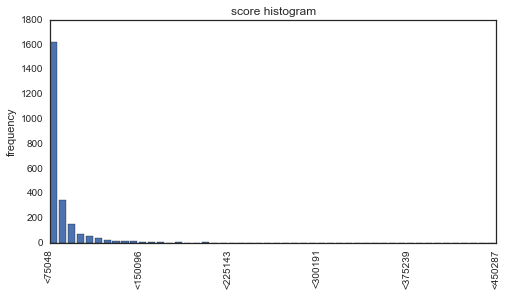

In [34]:
#create a histogram of a column's values
histdf=df1.score.hist(bins=50)

SELECT c_posts, AVG(score) score_mean , STDDEV(score) score_std , COUNT(score) score_count  FROM [fh-bigquery:reddit.subreddits] GROUP BY c_posts LIMIT 10000000


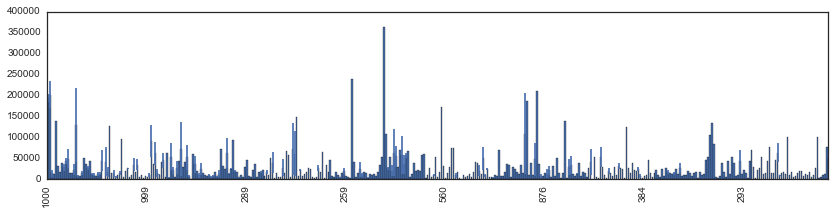

In [32]:
#create a simple plot (mean +/- 1 SEM) of value_col, broken down by grouping_col
value_col='score'
grouping_col='c_posts'
df1.plot(grouping_col, value_col, kind='bar')

Waiting on bqjob_r290ec64add5d7e21_0000014e911088c3_161 ... (0s) Current status: DONE   


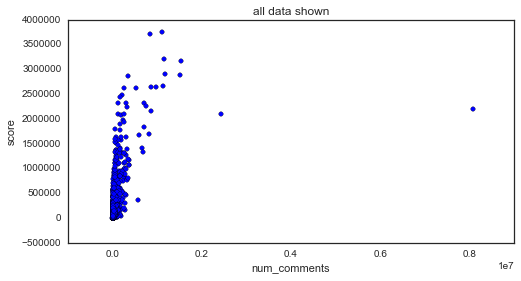

In [92]:
#create scatter plot of x vs. y (since bins > total number of datapoints, will plot all data)
scatterseries=df1.scatter('num_comments', 'score', bins=5000)

Waiting on bqjob_r4df8c31c0aaa2797_0000014e9295e225_511 ... (0s) Current status: DONE   
Waiting on bqjob_r538d521950396491_0000014e9295f60f_514 ... (0s) Current status: DONE   
Waiting on bqjob_r34486ffb3c830239_0000014e92960bb8_517 ... (0s) Current status: DONE   
[300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


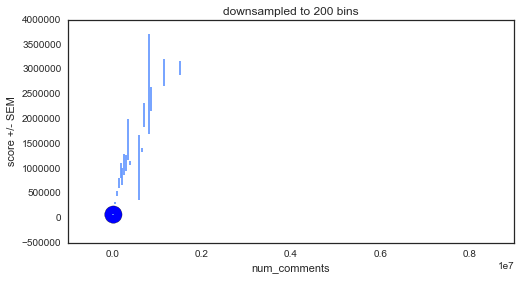

In [162]:
#create a downsampled scatter plot of x vs. y
plotdf=df1.scatter('num_comments', 'score', bins=200)

In [160]:
x.head()

,"date,user,query,destination,jobid,duration_ms,processed_mb,cached,"
0,2015-07-15 12:36:58.804015||amy.skerry@gmail.c...
1,2015-07-15 12:36:59.590460||amy.skerry@gmail.c...
2,2015-07-15 12:37:01.575764||amy.skerry@gmail.c...
3,2015-07-15 12:37:02.250906||amy.skerry@gmail.c...
4,2015-07-15 12:37:02.964831||amy.skerry@gmail.c...


In [159]:
x=pd.read_csv('log.csv', delimiter='||')


/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


##Misc

In [108]:
dir(client)

['CancelJob',
 'ConfigureFormatter',
 'ConstructObjectInfo',
 'ConstructObjectReference',
 'CopyTable',
 'CreateDataset',
 'CreateTable',
 'DatasetExists',
 'DeleteDataset',
 'DeleteTable',
 'ExecuteJob',
 'Extract',
 'FormatAcl',
 'FormatDatasetInfo',
 'FormatInfoByKind',
 'FormatJobInfo',
 'FormatProjectInfo',
 'FormatSchema',
 'FormatTableInfo',
 'FormatTime',
 'GetDatasetReference',
 'GetDiscoveryUrl',
 'GetHttp',
 'GetJobReference',
 'GetJobTypeName',
 'GetObjectInfo',
 'GetProjectReference',
 'GetQueryResults',
 'GetReference',
 'GetTableReference',
 'GetTableSchema',
 'InsertTableRows',
 'IsFailedJob',
 'ListDatasetRefs',
 'ListDatasets',
 'ListJobRefs',
 'ListJobs',
 'ListProjectRefs',
 'ListProjects',
 'ListTableRefs',
 'ListTables',
 'Load',
 'NormalizeWait',
 'PollJob',
 'ProcessSources',
 'Query',
 'QuietWaitPrinter',
 'RaiseError',
 'RaiseIfJobError',
 'ReadSchema',
 'ReadSchemaAndJobRows',
 'ReadSchemaAndRows',
 'RunJobSynchronously',
 'RunQuery',
 'RunQueryRpc',
 'StartJ

In [69]:
df1.__

In [22]:
df1['c_posts'].max()

1000

In [19]:
df1.active_col

'c_posts'

In [52]:
scatterseries=df1.scatter('c_posts', 'score')

BigqueryCommunicationError: Could not connect with BigQuery server due to: error(65, 'No route to host')

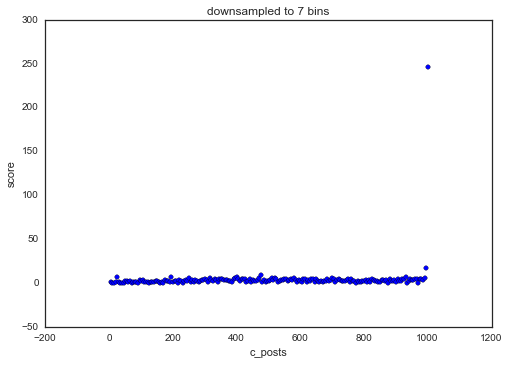

In [51]:
series=plot_scatter(scatterdf, 'c_posts', 'score')

In [59]:
plot_scatter?

In [62]:
plot_scatter.func_code

<code object plot_scatter at 0x109f927b0, file "<ipython-input-49-eb5bdebb588f>", line 1>